In [1]:
import numpy as np
import pandas as pd

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn import svm
from sklearn.model_selection import cross_val_score

/Users/chengjielin/tensorflow/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
price = pd.read_csv("price_data.csv",encoding = "ISO-8859-1")
news = pd.read_csv("news_data.csv",encoding = "ISO-8859-1")

In [3]:
price = price.drop(['id','exchange'], 1)
price=price.sort_values(by=['timestamp'],ascending=True)
price.head()

,price,timestamp
0,6999.8,1523132235
1,6984.1,1523133211
2,6984.1,1523133241
3,6984.1,1523133272
4,6984.1,1523133303


In [4]:
price=price[-31:]

In [5]:
len(price)

31

In [6]:
price = price.set_index('timestamp').diff(periods=1)
price['timestamp'] = price.index
price = price.reset_index(drop=True)
price.head()

,price,timestamp
0,NaN,1524181432
1,0.0,1524181462
2,0.0,1524181492
3,0.0,1524181523
4,0.0,1524181554


In [7]:
price = price[price.price.notnull()]
price

,price,timestamp
1,0.0,1524181462
2,0.0,1524181492
3,0.0,1524181523
4,0.0,1524181554
5,0.0,1524181585
6,0.0,1524181615
7,0.0,1524181646
8,0.0,1524181677
9,0.0,1524181708
10,0.0,1524181723


In [8]:
price_label = []
headlines = []
for row in price.iterrows():
    daily_headlines = []
    timestamp = row[1]['timestamp']
    price_label.append(row[1]['price'])
    i=0
    for row_ in news[news.time<=timestamp].iterrows() and news[news.time>(timestamp-30)].iterrows():
        #print (row_[1]['weight'])
        if(i<30):
            i=i+1
            daily_headlines.append(row_[1]['text'])
        else:
            continue
            
    justb = np.array(daily_headlines)
    #print (justb.shape)
    headlines.append(justb)
       #daily_headlines.append(row_[1]['text'])
       # justb = np.array(daily_headlines)
       # print (justb.shape)

In [9]:
headlines = np.array(headlines)
headlines.shape

(30, 30)

In [10]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [11]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [12]:
import re
from nltk.corpus import stopwords
clean_headlines = []

for daily_headlines in headlines:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [13]:
clean_headlines = np.array(clean_headlines)
clean_headlines.shape

(30, 30)

In [14]:
def add_avg_sentiment_list(data):
    sid = SentimentIntensityAnalyzer()
    avgs = []
    for i in range(0,len(data)):
        inner_avg=[]
        for j in range(0,len(data[0])):
            sentiments=(sid.polarity_scores(str(data[i][j]))['compound'])
            inner_avg.append(float(sentiments))
        avgs.append(inner_avg)
    avgs = np.array(avgs)
    print(avgs.shape)
    return avgs

In [15]:
sentiment_included = add_avg_sentiment_list(clean_headlines)
print("sentiment_include")
print(sentiment_included.shape)

(30, 30)
sentiment_include
(30, 30)


In [16]:
import numpy
mylist_label = np.asarray((price_label))
print(mylist_label[0:10])
print(mylist_label.shape)
mylist_label=numpy.reshape(mylist_label, (len(mylist_label),1))
mylist_label[0:10]

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
(30,)


array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [17]:
sum_set_timestep=sentiment_included.sum(axis=1)
sum_set_timestep=numpy.reshape(sum_set_timestep,(len(sum_set_timestep),1))
sum_set_timestep

array([[ 4.8163],
       [ 4.8163],
       [ 4.8163],
       [ 4.8163],
       [ 4.8163],
       [ 4.8163],
       [ 4.8163],
       [ 4.8163],
       [ 4.8163],
       [ 4.8163],
       [ 4.8163],
       [ 4.8163],
       [ 4.8375],
       [ 3.8653],
       [ 4.0486],
       [ 4.9149],
       [ 4.6786],
       [ 4.8152],
       [ 3.9632],
       [ 2.5091],
       [ 1.3391],
       [ 1.2877],
       [-1.3648],
       [ 0.6144],
       [ 3.3972],
       [ 3.3972],
       [ 3.3972],
       [ 3.3972],
       [ 3.3972],
       [ 3.3972]])

In [18]:
sum_set_timestep.shape

(30, 1)

In [19]:
sum_set_timestep=numpy.reshape(sum_set_timestep,(1,len(sum_set_timestep)))

In [20]:
sum_set_timestep.shape

(1, 30)

In [21]:
from keras.models import model_from_json

Using TensorFlow backend.


In [22]:
json_file = open('stock_lstm_noscale.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("stock_lstm_noscale.h5")
print("Loaded model from disk")

Loaded model from disk


In [23]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 32)            4352      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [24]:
loaded_model.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
lastone = loaded_model.predict(numpy.reshape(sum_set_timestep, (len(sum_set_timestep), 30, 1)), verbose = 0)

In [26]:
lastone

array([[[  1.29908368e-01],
        [  4.84573608e-03],
        [  1.95720975e-04],
        [  9.99420765e-04],
        [  7.23767234e-03],
        [  8.42683949e-03],
        [  7.12420559e-04],
        [  1.27261970e-03],
        [  3.21292989e-02],
        [  5.58896028e-02],
        [  2.56176735e-03],
        [  5.22352988e-04],
        [  2.49394216e-03],
        [  3.46444994e-01],
        [  5.12463078e-02],
        [  2.87921447e-03],
        [  5.84904337e-04],
        [  2.40734708e-03],
        [  3.07098866e-01],
        [  3.07443798e-01],
        [  9.93868858e-02],
        [  9.87806499e-01],
        [  9.23688471e-01],
        [  5.02098918e-01],
        [  1.56176183e-02],
        [  4.49878834e-02],
        [  9.36240703e-03],
        [  6.11187657e-04],
        [  1.28755550e-04],
        [  1.41042634e-04]]], dtype=float32)

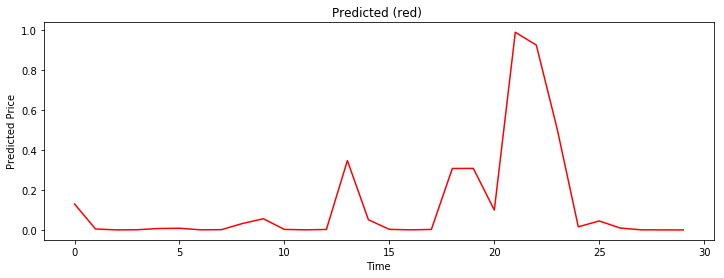

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(numpy.reshape(lastone, lastone[0].shape),'r')
plt.title("Predicted (red) ")
plt.xlabel("Time")
plt.ylabel("Predicted Price")
plt.show()